In [1]:
import pandas as pd
import vectorbtpro as vbt
from datetime import datetime, timedelta
import pytz
import numpy as np
import pandas_ta as ta
import logging
from backtesting import Strategy, Backtest
from backtesting.lib import resample_apply
logging.basicConfig(level=logging.WARNING, format='%(asctime)s %(message)s', datefmt='%m/%d/%Y %I:%M:%S %p')


/Users/ericervin/opt/anaconda3/envs/datascience/lib/python3.10/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)


In [2]:

start = "2018-01-01"
# Enter your parameters here
metric = 'total_return'

start_date = datetime(2020, 1, 1, tzinfo=pytz.utc)  # time period for analysis, must be timezone-aware
end_date = datetime.now(pytz.utc)
# end_date = datetime(2020, 1, 1, tzinfo=pytz.utc)

# The following is the number of days to look back for the analysis
time_buffer = timedelta(days=100)  # buffer before to pre-calculate SMA/EMA, best to set to max window
freq = '1h'

vbt.settings.portfolio['init_cash'] = 100_000.  # 100,000$
# vbt.settings.portfolio['fees'] = 0.0025  # 0.25%
# vbt.settings.portfolio['slippage'] = 0.0025  # 0.25%

# get binance data doing it this way allows for you to update your data rather than re-downloading it
# binance_data = vbt.BinanceData.fetch(symbols,timeframe=freq, start=start_date,end="now UTC")
# binance_data.save("binance_data.pkl")

# If you already have the data downloaded, you can load it
binance_data = vbt.BinanceData.load("binance_data.pkl")
# binance_data = binance_data.update() if you want to update it.
futures_path = '/Users/ericervin/Documents/Coding/data-repository/data/BTCUSDT_1m_futures.pkl'

In [3]:
btc = vbt.BinanceData.load(futures_path)
df = btc.get()

# Generate Entry Signals
For this I will generate an entry signal every day at midnight. The challenge will be to build a strategy that is able to choose the proper position size for the first and subsequent entries. Then take profit if the trade is quickly profitable and work itself out of a hole if the trade turns against it. I will perform this first on a strategy for long positions, then on short positions. Then we will attempt to see if we can run the strategy for more intelligent entry points. 

In [4]:
# create a signal array the same length as the dataframe
signal = np.zeros(len(df))
signal = pd.Series(signal, index=df.index)
# set the signal to 1 at midnight UTC
signal[df.at_time('00:00').index] = 1
# Create a -1 right before the signal
signal[df.at_time('23:59').index] = -1 # for exiting 1 minute before midnight
df['signal'] = signal
# Convert to int
df['signal'] = df['signal'].astype(int)
df['signal'].sum()

1

In [5]:

short_df = df.loc['2023']

In [6]:
# Create a benchmark strategy class that shows the impact of buying every day at midnight UTC and closing the trade at the end of the day
class Benchmark_Long(Strategy):
    def SIGNAL(self):
        return self.data.signal
    def init(self):
        super().init()
        self.signal = self.I(self.SIGNAL)
    
    def next(self):
        super().next()
        if self.signal == 1:
            self.buy()
        elif self.signal == -1:
            self.position.close()

## Run this if you want to see what a benchmark would be.
Notably if you went long the market every day and closed your position at the end of day, you would only have about a 50% win rate.

In [7]:
# bt = Backtest(short_df, Benchmark_Long, cash=100_000, exclusive_orders=False)
# stats = bt.run()
# stats

Note ~ 50% of the days are positive and 50 are negative. So choosing an up or a down day is totally random. This should help with our testing.

# Create a money management strategy
We will have a quick profit rule, if the market moves in your favor you exit the position with a profit. Else, you fight like hell to manage the postion and end up with a profit.

### Let's also add the decay function
Below is an example of how the decay function will work within our class. 

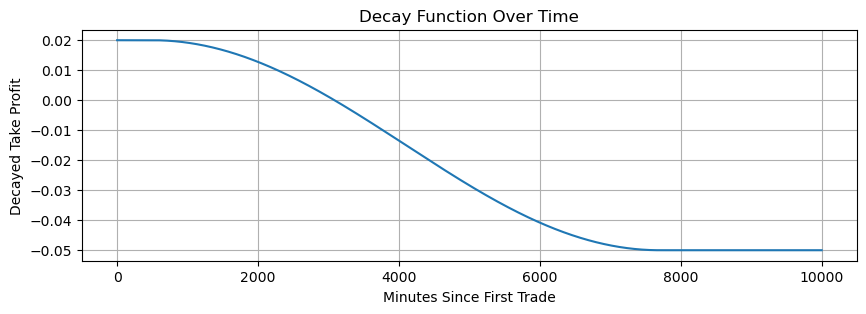

In [125]:
import numpy as np
import matplotlib.pyplot as plt

# Define the custom decay function
def custom_decay_func(x, delay_period, upper_bound, lower_bound, delta_time):
    if x <= delay_period:
        return upper_bound
    elif delay_period < x < delay_period + delta_time:
        # Calculate the x value for the cos function
        transition_x = (x - delay_period) / delta_time * np.pi
        return (-np.cos(transition_x) + 1) / 2 * (lower_bound - upper_bound) + upper_bound
    else:
        return lower_bound

# Define the parameters
delay_period = 500  # 60 minutes
upper_bound = 0.02 # Target Profit
lower_bound = -0.05 # Worst acceptable loss
delta_time = 60*24*5  # how long the decay period lasts before leveling off

# Create an array of x values from 0 to 5000 minutes
x_values = np.linspace(0, 10000, 5001)

# Calculate the y values
y_values = [custom_decay_func(x, delay_period, upper_bound, lower_bound, delta_time) for x in x_values]

# Create the plot
plt.figure(figsize=(10, 3))
plt.plot(x_values, y_values)
plt.title('Decay Function Over Time')
plt.xlabel('Minutes Since First Trade')
plt.ylabel('Decayed Take Profit')
plt.grid(True)
plt.show()


### Build the strategy

In [126]:

        
from tqdm.notebook import tqdm

class Underwater_w_decay(Strategy):
    initial_position_size = 0.1
    # take_profit = 0.03
    atr_length = 14 # 14 days
    atr_multiplier = 0.2
    add_size = 0.15
    delay_period = 1000
    delta_time = 5000
    upper_bound = 0.05
    lower_bound = -0.05

    def SIGNAL(self):
        return self.data.signal

    def ATR(self, df, length):
        return df.ta.atr(length=length)
    
    def custom_decay_func(self, x, delay_period, upper_bound, lower_bound, delta_time):
        if x <= delay_period:
            return upper_bound
        elif delay_period < x < delay_period + delta_time:
            # Calculate the x value for the cos function
            transition_x = (x - delay_period) / delta_time * np.pi
            return (-np.cos(transition_x) + 1) / 2 * (lower_bound - upper_bound) + upper_bound
        else:
            return lower_bound
    
    def init(self):
        super().init()
        self.signal = self.I(self.SIGNAL)
        self.atr = self.I(self.ATR, self.data.df, self.atr_length)
        self.daily_atr = resample_apply('1D', self.ATR, self.data.df, length=14)
        self.pbar = None
        count_NaN = len(self.atr) - len(pd.Series(self.atr).dropna())
        self.length_of_data = len(self.data.Close) - count_NaN
        
    def next(self):
        super().next()

        if self.pbar is None:
            self.pbar = tqdm(total=self.length_of_data, desc='Backtesting')
        self.pbar.update()
        self.pbar.set_description("Backtesting (equity: {:.2f})".format(self.equity)) 
        
        price = self.data.Close[-1]
        position_value = self.position.size*price
        position_avg_price = (position_value-self.position.pl)/self.position.size
        atr_threshold = self.atr_multiplier*self.daily_atr/price 


        # Calculate the number of bars since the first trade was entered
        if len(self.trades) > 0 and self.trades[0].is_long:
            self.first_trade_entry_bar = self.trades[0].entry_bar
            bars_since_first_trade = len(self.data.Close) - self.first_trade_entry_bar
        else:
            bars_since_first_trade = 0


        # Calculate the decayed take profit
        decayed_take_profit = self.custom_decay_func(bars_since_first_trade, self.delay_period, self.upper_bound, self.lower_bound, self.delta_time)
        
        if self.position.pl_pct > decayed_take_profit:
            self.position.close()
            
        elif self.position.size > 0 and self.position.pl_pct < -(atr_threshold): 
            # Check to see if we are also down on our last trade
            if self.trades[-1].pl_pct < -atr_threshold:
                self.buy(size = self.add_size)
                
        elif not self.position and self.signal == 1:
            self.buy(size = self.initial_position_size) 
    
    def finalize(self): # TODO I don't even think this function is called anywhere. Not sure if it matters
        self.pbar.close()

start = '2021-01-01'
end = '2022-3-31'
bt = Backtest(df.loc[start:end], Underwater_w_decay, cash=100_000_000, exclusive_orders=False, trade_on_close=True)
stats = bt.run()
print(stats)


Backtesting:   0%|          | 0/655186 [00:00<?, ?it/s]

In [121]:
# bt.plot(resample=False)
bt.plot()

/Users/ericervin/opt/anaconda3/envs/datascience/lib/python3.10/site-packages/backtesting/_plotting.py:122: UserWarning: Data contains too many candlesticks to plot; downsampling to '2H'. See `Backtest.plot(resample=...)`
  warnings.warn(f"Data contains too many candlesticks to plot; downsampling to {freq!r}. "


GridPlot(id='p35259', ...)

In [ ]:
stats['_equity_curve']['Equity'].resample('1h').plot()